# 001_Intersection_Over_Union

In [1]:
import torch

In [53]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  """
  Parameters: 
    boxes_preds (tensor): Predictions of bounding boxes (BATCH_SIZE x 4)
    boxes_labels (tensor): Ground truths of bounding boxes (BATCH_SIZE x 4)
    box_format (str): midpoint (x,y,w,h) or corners (x1,y1,x2,y2)

  Returns: 
    tensor: intersection over union over all examples
  """

  if box_format == "midpoint":
    box1_x1 = boxes_preds[:, 0:1] - boxes_preds[:, 2:3]/2
    box1_y1 = boxes_preds[:, 1:2] - boxes_preds[:, 3:4]/2
    box1_x2 = boxes_preds[:, 0:1] + boxes_preds[:, 2:3]/2
    box1_y2 = boxes_preds[:, 1:2] + boxes_preds[:, 3:4]/2

    box2_x1 = boxes_labels[:, 0:1] - boxes_labels[:, 2:3]/2
    box2_y1 = boxes_labels[:, 1:2] - boxes_labels[:, 3:4]/2
    box2_x2 = boxes_labels[:, 0:1] + boxes_labels[:, 2:3]/2
    box2_y2 = boxes_labels[:, 1:2] + boxes_labels[:, 3:4]/2

  if box_format == "corners":
    box1_x1 = boxes_preds[:, 0:1]
    box1_y1 = boxes_preds[:, 1:2]
    box1_x2 = boxes_preds[:, 2:3]
    box1_y2 = boxes_preds[:, 3:4]

    box2_x1 = boxes_labels[:, 0:1]
    box2_y1 = boxes_labels[:, 1:2]
    box2_x2 = boxes_labels[:, 2:3]
    box2_y2 = boxes_labels[:, 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  return intersection / (box1_area + box2_area - intersection)

# 002_Non_Max_Suppression

### NMS Suppression Algo - 

1. Among all the bounding boxes we obtained remove all those bboxes 
  - where pc < probability_threshold.
    - pc = probability of confidence of object being present
2. while we have bboxes:
      - take out the largest pc box
      - remove all the other bboxes with IoU > threshold
3. Repeat step 2 for all classes

In [49]:
import torch

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
  # bboxes: [[class,prob_confidence,x1,y1,x2,y2],[...],[...]]
  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > threshold]
  bboxes = sorted(bboxes, key=lambda x:x[1], reverse=True)
  bboxes_after_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [
              box 
              for box in bboxes 
              if box[0] != chosen_box[0] 
              or intersection_over_union(torch.tensor(chosen_box[2:]),
                                         torch.tensor(box[2:]),
                                         box_format=box_format) < iou_threshold
    ]

    bboxes_after_nms.append(chosen_box)

  return bboxes_after_nms

# 003_Mean_Average_Precision

In [4]:
import torch
from collections import Counter

In [51]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [6]:
# Example of Counter
mp = Counter([0,0,0,1,1,1,1])
print(mp)   # image_1 has 4 bboxes, image_0 has 3 bboxes

Counter({1: 4, 0: 3})


# 004_YOLO_Architecture

In [7]:
import torch
import torch.nn as nn

https://arxiv.org/pdf/1506.02640.pdf

**YOLO Architecture**
![Screenshot 2021-02-19 at 10 37 14](https://user-images.githubusercontent.com/26361028/108460333-6fbd2c80-729e-11eb-8e43-b2d0f546575f.png)


In [8]:
architecture_config = [
  # Tuple: (kernel_size, filters, stride, padding)
  (7,64,2,3),
  "M",
  (3,192,1,1),
  "M",
  (1,128,1,0),
  (3,256,1,0),
  (1,256,1,0),
  (3,512,1,1),
  "M",
  [(1,256,1,0),(3,512,1,1),4],
  (1,512,1,0),
  (3,512,1,1),
  "M",
  [(1,512,1,0),(3,1024,1,1),2],
  (3,1024,1,1),
  (3,1024,2,1),
  (3,1024,1,1),
  (3,1024,1,1)
]

In [9]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self,x):
    x = self.leakyrelu(self.batchnorm(self.conv(x)))
    return x  

In [10]:
class Yolov1(nn.Module):
  def __init__(self, in_channels=3, **kwargs):
    super(Yolov1, self).__init__()
    self.architecture = architecture_config
    self.in_channels = in_channels
    self.darknet = self._create_conv_layers(self.architecture)
    self.fc = self._create_fc(**kwargs)

  def forward(self, x):
    x = self.darknet(x)
    x = torch.flatten(x, start_dim=1)
    return self.fc(x)

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == tuple:
        layers += [
          CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])
        ]
        in_channels = x[1]
      elif type(x) == str:
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
      elif type(x) == list:
        conv1 = x[0] # tuple
        conv2 = x[1] # tuple
        num_repeats = x[2] # integer
        for _ in range(num_repeats):
          layers += [
            CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]),
            CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]),
          ]
          in_channels = conv2[1]
    return nn.Sequential(*layers)
  
  def _create_fc(self, split_size, num_boxes, num_classes):
    S,B,C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * S * S, 496),
        nn.Dropout(0.5),
        nn.LeakyReLU(0.1),
        nn.Linear(496, S*S*(C+B*5)) # C+B*5 = 30
    )

In [11]:
def test(S=7, B=2, C=20):
  model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
  x = torch.randn((2, 3, 448, 448))
  return model(x)

In [12]:
output = test()
print(output.shape)
output = output.reshape(output.shape[0],7,7,30)
print(output.shape)   # 2x7x7x30 => Two batches, each batch has 7x7x30 output, where each 7x7 has label prediction consisting (20 num_classes, 1 pred_score, 4 bboxes, 1 pred_score, 4 bboxes)

torch.Size([2, 1470])
torch.Size([2, 7, 7, 30])


![Screenshot 2021-02-19 at 11 48 17](https://user-images.githubusercontent.com/26361028/108465619-5caf5a00-72a8-11eb-8920-8eafdc9bdeb3.png)


In [62]:
# Implementing Loss

import torch 
import torch.nn as nn

class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# 005_Dataset Preparation

In [17]:
%cd '/content/drive/MyDrive/Datasets/pascal_voc_2012'
!ls

/content/drive/MyDrive/Datasets/pascal_voc_2012
Dataset.zip


In [18]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: labels/2009_004289.txt  
  inflating: labels/2009_004290.txt  
  inflating: labels/2009_004291.txt  
  inflating: labels/2009_004295.txt  
  inflating: labels/2009_004298.txt  
  inflating: labels/2009_004300.txt  
  inflating: labels/2009_004301.txt  
  inflating: labels/2009_004303.txt  
  inflating: labels/2009_004307.txt  
  inflating: labels/2009_004308.txt  
  inflating: labels/2009_004309.txt  
  inflating: labels/2009_004312.txt  
  inflating: labels/2009_004315.txt  
  inflating: labels/2009_004316.txt  
  inflating: labels/2009_004317.txt  
  inflating: labels/2009_004319.txt  
  inflating: labels/2009_004322.txt  
  inflating: labels/2009_004323.txt  
  inflating: labels/2009_004324.txt  
  inflating: labels/2009_004327.txt  
  inflating: labels/2009_004328.txt  
  inflating: labels/2009_004329.txt  
  inflating: labels/2009_004332.txt  
  inflating: labels/2009_004334.txt  
  inflating: labels/2009_004336.txt  

In [19]:
!ls

100examples.csv  Dataset.zip	  get_data  labels    train.csv
8examples.csv	 generate_csv.py  images    test.csv


In [22]:
# Directories
root_dir = '/content/drive/MyDrive/Datasets/pascal_voc_2012'
csv_dir = root_dir + '/train.csv'
test_dir = root_dir + '/test.csv'
img_dir = root_dir + '/images'
label_dir = root_dir + '/labels'

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

import os
import pandas as pd
from PIL import Image

In [21]:
class VOCDataset(Dataset):
  def __init__(self, csv_file, img_dir ,label_dir, S=7, B=2, C=20, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.S = 7
    self.B = 2
    self.C = 20

  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir, self.annotations.iloc[index,1])
    boxes = []
    with open(label_path) as f:
      for label in f.readlines():
        class_label, x, y, width, height = [
          float(x) if float(x) != int(float(x)) else int(x)
          for x in label.replace("\n","").split()
        ]
        boxes.append([class_label, x, y, width, height])
    
    img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
    image = Image.open(img_path)
    boxes = torch.tensor(boxes)

    if self.transform:
      image, boxes = self.transform(image, boxes)
    
    label_matrix = torch.zeros((self.S, self.S, self.C + 5*self.B))
    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)
      i, j = int(self.S * y), int(self.S * x)
      x_cell, y_cell = self.S * x - j, self.S * y - i
      width_cell, height_cell = (
          width * self.S,
          height * self.S
      )
      if label_matrix[i,j,20] == 0:
        label_matrix[i,j,20] = 1
        box_coordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )
        label_matrix[i,j,21:25] = box_coordinates
        label_matrix[i,j,class_label] = 1

    return image, label_matrix

In [23]:
dataset = VOCDataset(csv_file=csv_dir, img_dir=img_dir, label_dir=label_dir)
print(len(dataset))

16550


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


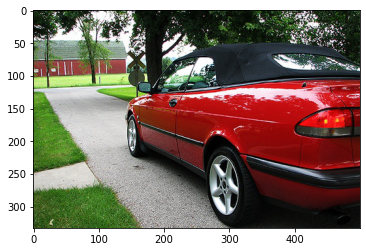

In [30]:
import matplotlib.pyplot as plt

image, label_matrix = dataset[0]
plt.imshow(image,cmap='gray')
print(label_matrix[5][5])

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [33]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [34]:
seed = 123
torch.manual_seed(seed)

In [43]:
# Hyperparameters
lr = 2e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weight_decay = 0
batch_size = 16
epochs = 100
num_workers = 8
load_model = False
load_model_file = "overfit.pth.tar"

In [46]:
from torchvision.transforms import transforms

class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, img, bboxes):
    for t in self.transforms:
      img, bboxes = t(img), bboxes
  
    return img, bboxes


transform = Compose([transforms.Resize((448,448)),
                     transforms.ToTensor()])

In [39]:
from tqdm import tqdm
def train_fn(train_loader, model, optimizer, loss_fn):
  loop = tqdm(train_loader, leave=True)
  mean_loss = []

  for batch_idx, (x,y) in enumerate(loop):
    x,y = x.to(device), y.to(device)
    out = model(x)
    loss = loss_fn(out, y)
    mean_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # update the progress bar
    loop.set_postfix(loss=loss.item())

  print(f'Mean loss: {sum(mean_loss)/len(mean_loss)}')


In [63]:
import torch.optim as optim

model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = YoloLoss()

if load_model:
  load_checkpoint(torch.load(load_model_file), model, optimizer)

train_set = VOCDataset(root_dir+'/8examples.csv', img_dir=img_dir, label_dir=label_dir, transform=transform)
test_set = VOCDataset(root_dir+'/test.csv', img_dir=img_dir, label_dir=label_dir, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

In [63]:
for epoch in range(epochs):
  pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

  mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, box_format="midpoint")

  print(f'Train mAP: {mean_avg_prec}')
  train_fn(train_loader, model, optimizer, loss_fn)